In [29]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t, genpareto, norm
import seaborn as sns
import statsmodels.api as sm


In [30]:
df = pd.read_csv('QRM-2024-cw2-data.csv')

In [31]:
df['Log_Returns'] = np.log(df['TSLA'] / df['TSLA'].shift(1)) * 100
df['Lin_Loss'] =df['Log_Returns']*(-1)
df['Date'] = pd.to_datetime(df['Date'])
df.dropna(inplace=True)

train_data = df[df['Date'] < '2021-11-26']['Lin_Loss']
test_data = df[df['Date'] >= '2021-11-26']['Lin_Loss']


In [32]:
print(train_data)

1       0.372556
2      -3.304064
3      -1.374813
4      -0.385143
5      -2.337906
          ...   
2262   -0.674481
2263   -3.643214
2264   -1.727210
2265    4.223230
2266   -0.626511
Name: Lin_Loss, Length: 2266, dtype: float64


In [33]:
model = arch_model(train_data, vol='Garch', p=1, q=1, mean='Constant', dist='normal')
res = model.fit(disp='off')

In [34]:
res.params

mu         -0.150610
omega       0.139015
alpha[1]    0.040944
beta[1]     0.948221
Name: params, dtype: float64

In [35]:
c1 = "#05668D"
c2 = "#FA9864"
c3 = "#C20114"

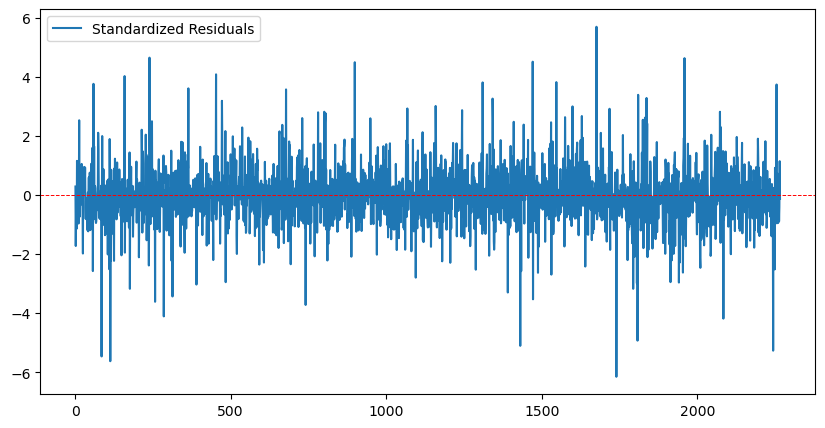

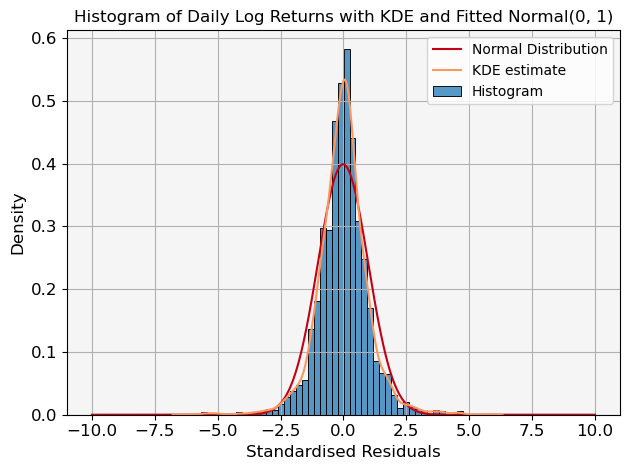

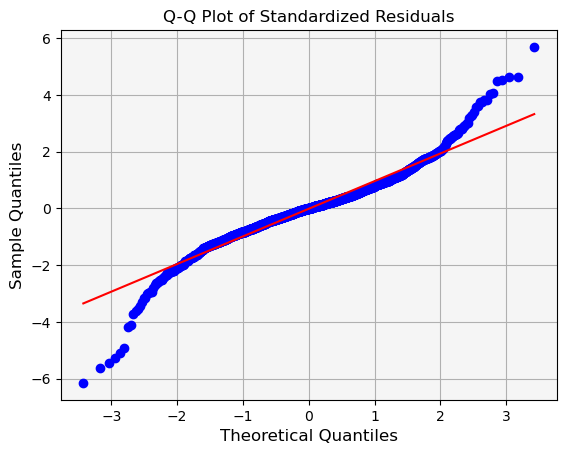

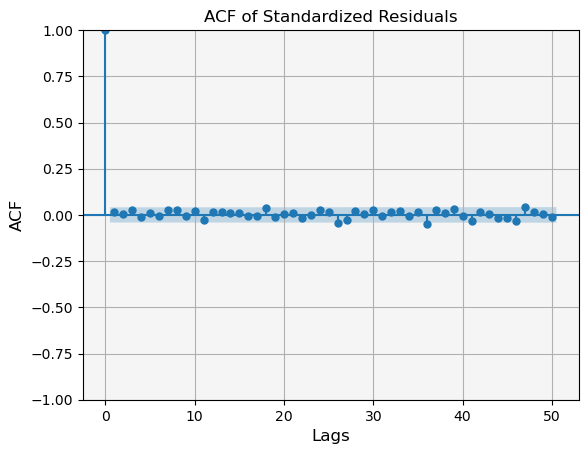

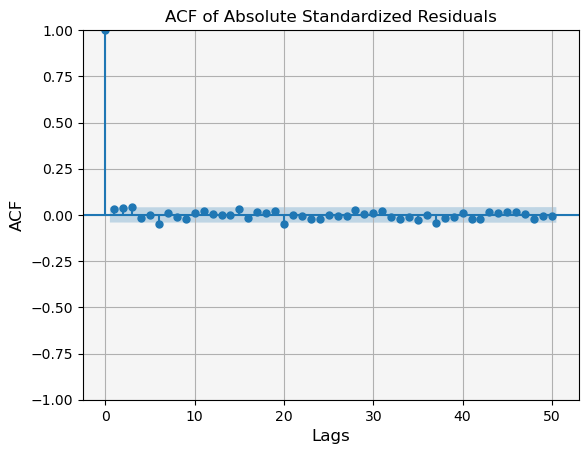

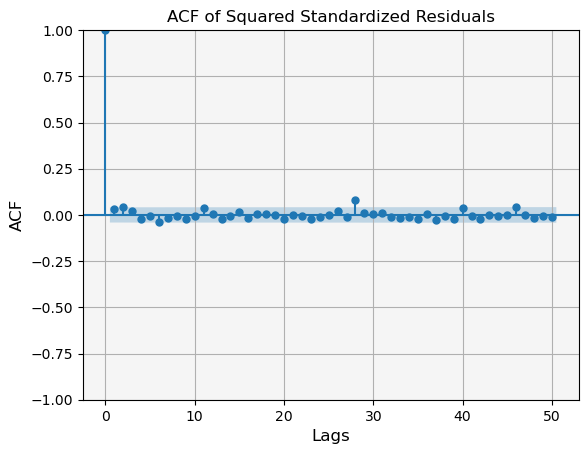

In [36]:
std_residuals = res.resid / res.conditional_volatility

plt.figure(figsize=(10, 5))
plt.plot(std_residuals, label='Standardized Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=0.7)
plt.legend()
plt.show()



n=len(std_residuals)
sns_hist=sns.histplot(std_residuals,bins=50,stat="density", label='Histogram')
x=np.linspace(-10,10,5000)
mu=np.mean(std_residuals)
sd=np.sqrt(np.var(std_residuals,ddof=1))
plt.xlabel("Standardised Residuals",size=12)
plt.ylabel("Density",size=12)
x=np.linspace(-10,10,5000)
sns_hist.plot(x,stats.norm.pdf(x,mu,sd),label="Normal Distribution",color=c3)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
sns.kdeplot(std_residuals,color=c2,label="KDE estimate")
plt.title("Histogram of Daily Log Returns with KDE and Fitted Normal(0, 1)")
plt.grid()
plt.gca().set_facecolor('whitesmoke')
plt.legend()
plt.tight_layout()
plt.show()

stats.probplot(std_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Standardized Residuals")
plt.xlabel("Theoretical Quantiles",size=12)
plt.ylabel("Sample Quantiles",size=12)
plt.grid()
plt.gca().set_facecolor('whitesmoke')
plt.show()


plot_acf(std_residuals, lags=50)
plt.title("ACF of Standardized Residuals")
plt.xlabel("Lags",size=12)
plt.ylabel("ACF",size=12)
plt.grid()
plt.gca().set_facecolor('whitesmoke')
plt.show()

plot_acf(abs(std_residuals), lags=50)
plt.title("ACF of Absolute Standardized Residuals")
plt.xlabel("Lags",size=12)
plt.ylabel("ACF",size=12)
plt.grid()
plt.gca().set_facecolor('whitesmoke')
plt.show()

plot_acf(np.square(std_residuals), lags=50)
plt.title("ACF of Squared Standardized Residuals")
plt.xlabel("Lags",size=12)
plt.ylabel("ACF",size=12)
plt.grid()
plt.gca().set_facecolor('whitesmoke')
plt.show()

In [37]:
std_residuals

1       0.285322
2      -1.725954
3      -0.635442
4      -0.121604
5      -1.142008
          ...   
2262   -0.130877
2263   -0.891654
2264   -0.404564
2265    1.143070
2266   -0.123682
Length: 2266, dtype: float64

Estimated Degrees of Freedom (ν): 3.560147359752372
Location (μ): -0.014173871257913296
Scale (σ): 0.6858888680637825


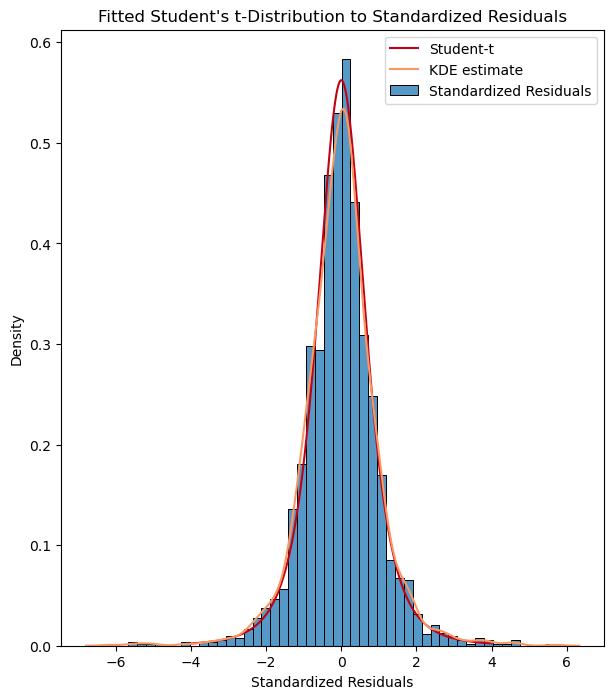

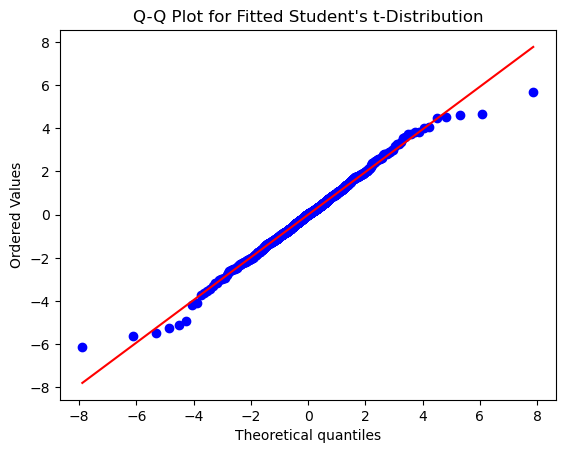

In [38]:
df_fit, loc_fit, scale_fit = t.fit(std_residuals)


print(f"Estimated Degrees of Freedom (ν): {df_fit}")
print(f"Location (μ): {loc_fit}")
print(f"Scale (σ): {scale_fit}")
x=np.linspace(-10,10,5000)
scale_standardized = np.sqrt((df_fit - 2) / df_fit)
plt.figure(figsize=(7,8))
t_x=np.linspace(-4,4,len(x))
sns_ax=sns.histplot(data=std_residuals,bins=50,stat="density",label="Standardized Residuals")
sns_ax.plot(t_x,stats.t.pdf(t_x,df=df_fit,scale=scale_standardized),label="Student-t",color=c3)
sns.kdeplot(std_residuals,color=c2,label="KDE estimate")
plt.title("Fitted Student's t-Distribution to Standardized Residuals")
plt.xlabel("Standardized Residuals")
plt.ylabel("Density")
plt.legend()
plt.show()


stats.probplot(std_residuals, dist="t", sparams=(df_fit, loc_fit, scale_fit), plot=plt)
plt.title("Q-Q Plot for Fitted Student's t-Distribution")
plt.show()

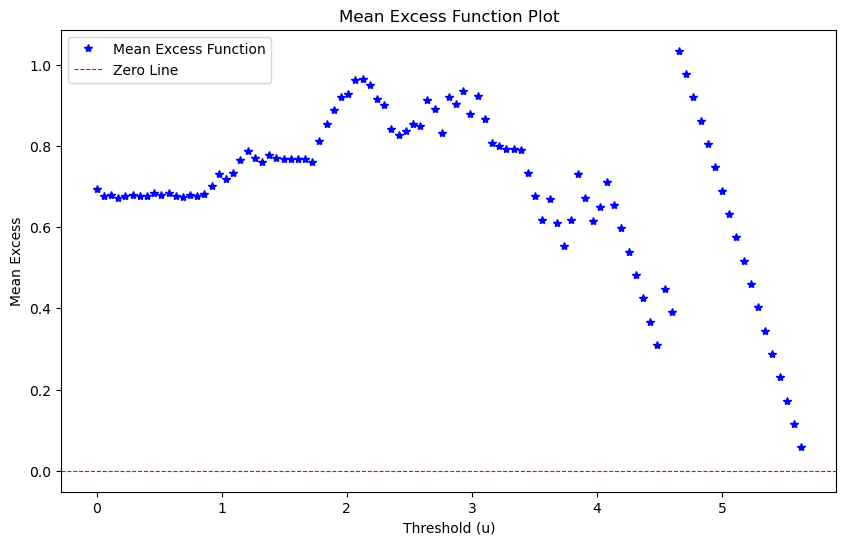

Fitted GPD Parameters:
Shape (ξ): 0.09594405156134633, Scale (β): 0.657749569013877


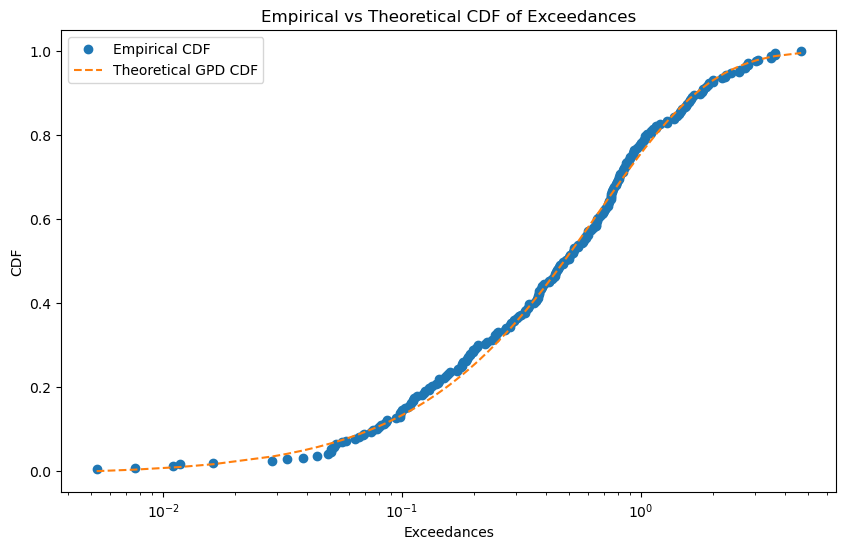

In [39]:

thresholds = np.linspace(0, std_residuals.max(), 100)
mean_excess = [np.mean(std_residuals[std_residuals > u] - u) for u in thresholds]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_excess, "b*", label="Mean Excess Function")
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label="Zero Line")
plt.title("Mean Excess Function Plot")
plt.xlabel("Threshold (u)")
plt.ylabel("Mean Excess")
plt.legend()
plt.show()


u = 1

exceedances = std_residuals[std_residuals > u] - u

shape, loc, scale = genpareto.fit(exceedances, loc=0)
print(f"Fitted GPD Parameters:\nShape (ξ): {shape}, Scale (β): {scale}")

sorted_exceedances = np.sort(exceedances)
ecdf = np.arange(1, len(sorted_exceedances)+1) / len(sorted_exceedances)
theoretical_cdf = genpareto.cdf(sorted_exceedances, shape, loc, scale)

plt.figure(figsize=(10, 6))
plt.plot(sorted_exceedances, ecdf, label="Empirical CDF", marker='o', linestyle='')
plt.plot(sorted_exceedances, theoretical_cdf, label="Theoretical GPD CDF", linestyle='--')
plt.title("Empirical vs Theoretical CDF of Exceedances")
plt.xlabel("Exceedances")
plt.xscale('log')
plt.ylabel("CDF")
plt.legend()
plt.show()


In [40]:
print(res.params)

mu         -0.150610
omega       0.139015
alpha[1]    0.040944
beta[1]     0.948221
Name: params, dtype: float64


In [41]:
train_data_r = train_data.values

In [42]:
train_data

1       0.372556
2      -3.304064
3      -1.374813
4      -0.385143
5      -2.337906
          ...   
2262   -0.674481
2263   -3.643214
2264   -1.727210
2265    4.223230
2266   -0.626511
Name: Lin_Loss, Length: 2266, dtype: float64

In [43]:
train_data_r[0]

0.3725555958566294

In [44]:


mu, alpha_0, alpha_1, beta_1 = res.params

test_returns = test_data.values
n = len(df)

sigma_squared = np.zeros(n)

sigma_squared[0] = var=np.var(train_data,ddof=1)

for t in range(1, len(train_data_r)+1):
    sigma_squared[t] = alpha_0 + alpha_1 * (train_data_r[t-1] - mu)**2 + beta_1 * sigma_squared[t-1]



In [45]:
dates=df['Date'][2266:].to_numpy()
index = [pd.to_datetime(date, format='%m/%d/%Y').date() for date in dates]

In [46]:
len(dates)

252

In [47]:
test_data_r = test_data.values

In [48]:
#now implement n 1-step ahead estimations of sigma using the training data
for i in range(0,len(test_data_r)):
    sigma_squared[len(train_data_r)+i]=alpha_0 + alpha_1 * (test_data_r[i-1]-mu)**2 + beta_1 * sigma_squared[i+len(train_data_r)-1]

In [49]:
sigma_squared[-10:]

array([16.52786437, 16.08044098, 15.695475  , 15.1333016 , 15.17184185,
       14.7193559 , 14.22753317, 15.77179575, 15.13992907, 16.72522023])

15.329689037709736


Text(0, 0.5, 'Positive part of Linearised Losses (%)')

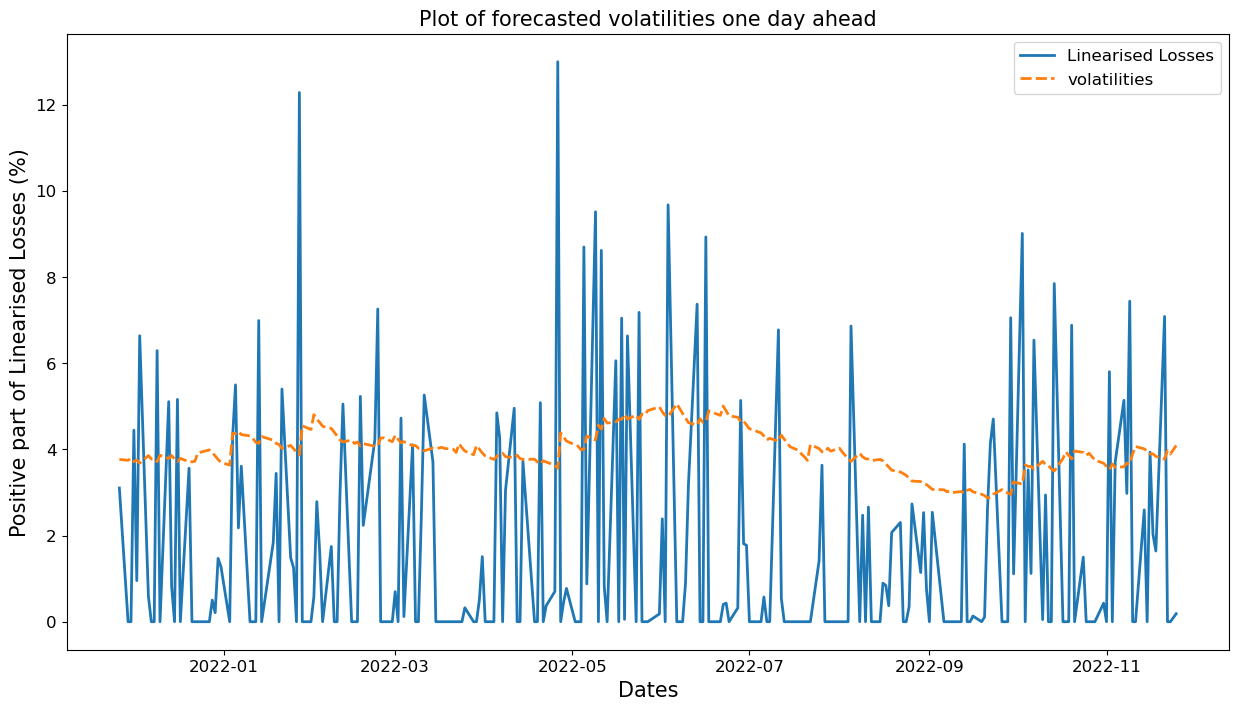

In [50]:
y=[i if i>0 else 0 for i in test_data]
plt.figure(figsize=(15,8))
print(sigma_squared[2285])

df_to_plot=pd.DataFrame({"Linearised Losses":y,"volatilities":np.sqrt(sigma_squared[2266:])}, index=index)
sns.lineplot(data=df_to_plot,linewidth=2)
plt.title("Plot of forecasted volatilities one day ahead",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [51]:
q95_norm=stats.norm.ppf(0.95)
q99_norm=stats.norm.ppf(0.99)

ZES95_norm=stats.norm.pdf(q95_norm)/(1-0.95)
ZES99_norm=stats.norm.pdf(q99_norm)/(1-0.99)

In [52]:

var95_norm=mu+np.sqrt(sigma_squared[2266:])*q95_norm
var99_norm=mu+np.sqrt(sigma_squared[2266:])*q99_norm
ES95_norm=mu+np.sqrt(sigma_squared[2266:])*ZES95_norm
ES99_norm=mu+np.sqrt(sigma_squared[2266:])*ZES99_norm

Text(0, 0.5, 'Positive part of Linearised Losses (%)')

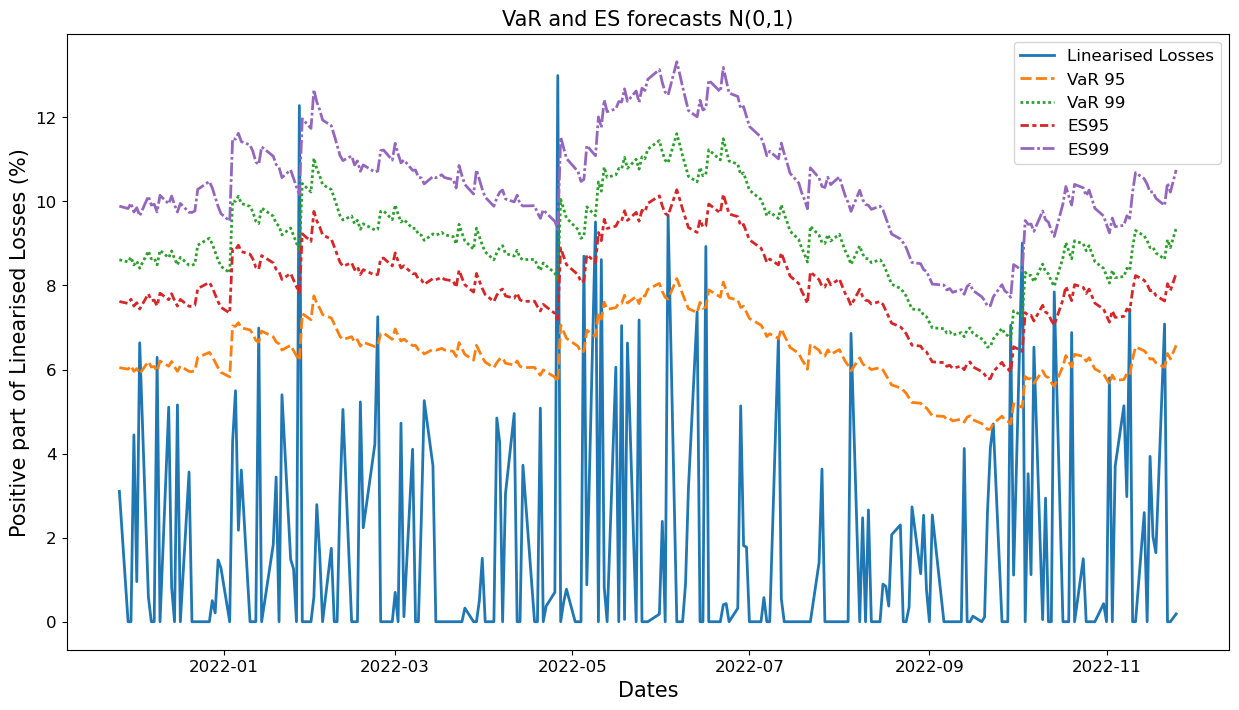

In [53]:
y=[i if i>0 else 0 for i in test_data]
plt.figure(figsize=(15,8))
df_to_plot=pd.DataFrame({"Linearised Losses":y,"VaR 95":var95_norm,"VaR 99":var99_norm,"ES95":ES95_norm,"ES99":ES99_norm}, index=index)
sns.lineplot(data=df_to_plot,linewidth=2)
plt.title("VaR and ES forecasts N(0,1)",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [54]:
def Unconditional_Test(data,VaR,alpha):
    violations=[data>VaR]
    num_violations=np.sum(violations)
    pihat=num_violations/len(data)

    Lalpha=(alpha)**(len(data)-num_violations)*(1-alpha)**num_violations
    Lpi=(1-pihat)**(len(data)-num_violations)*pihat**num_violations

    LRuc=-2*np.log(Lalpha/Lpi)
    print("Number of violations:",num_violations)
    print("Pi hat:",pihat)
    return(LRuc)

In [55]:
LRuc95=Unconditional_Test(test_data,var95_norm,0.95)
pval95=1-stats.chi2.cdf(LRuc95,1)
print(LRuc95)
print(pval95)

Number of violations: 22
Pi hat: 0.0873015873015873
6.097225401327241
0.013539430301558353


In [56]:
LRuc99=Unconditional_Test(test_data,var99_norm,0.99)
pval99=1-stats.chi2.cdf(LRuc99,1)
print(LRuc99)
print(pval99)

Number of violations: 4
Pi hat: 0.015873015873015872
0.745080952274408
0.3880381133603774


T STUDENT

In [57]:
scale_standardized = np.sqrt((df_fit - 2) / df_fit)

In [58]:


q95_t = stats.t.ppf(0.95, df=df_fit, scale=scale_standardized)
q99_t = stats.t.ppf(0.99, df=df_fit, scale=scale_standardized)


tES95 = (
    stats.t.pdf(q95_t, df=df_fit, scale=scale_standardized) / (1 - 0.95)
    * ((df_fit + q95_t**2) / (df_fit - 1))
)
tES99 = (
    stats.t.pdf(q99_t, df=df_fit, scale=scale_standardized) / (1 - 0.99)
    * ((df_fit + q99_t**2) / (df_fit - 1))
)

In [59]:
var95_t=mu+np.sqrt(sigma_squared[2266:])*q95_t
var99_t=mu+np.sqrt(sigma_squared[2266:])*q99_t
ES95_t=mu+np.sqrt(sigma_squared[2266:])*tES95
ES99_t=mu+np.sqrt(sigma_squared[2266:])*tES99

Text(0, 0.5, 'Positive part of Linearised Losses (%)')

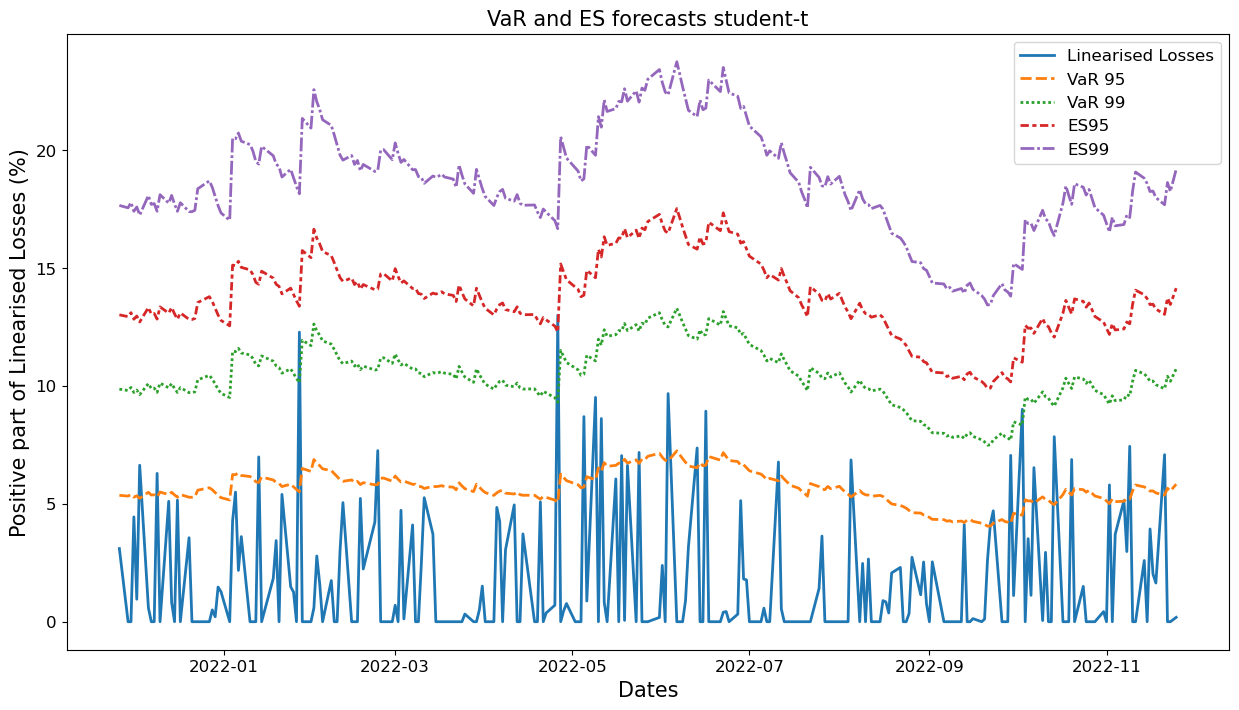

In [60]:
plt.figure(figsize=(15,8))
df_to_plot=pd.DataFrame({"Linearised Losses":y,"VaR 95":var95_t,"VaR 99":var99_t,"ES95":ES95_t,"ES99":ES99_t}, index=index)
sns.lineplot(data=df_to_plot,linewidth=2)
plt.title("VaR and ES forecasts student-t",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [61]:
len(var95_t)

252

In [62]:
LRuc95=Unconditional_Test(test_data,var95_t,0.95)
pval95=1-stats.chi2.cdf(LRuc95,1)
print(LRuc95)
print(pval95)

Number of violations: 27
Pi hat: 0.10714285714285714
13.23963689677873
0.00027409099916020363


In [63]:
LRuc99=Unconditional_Test(test_data,var99_t,0.99)
pval99=1-stats.chi2.cdf(LRuc99,1)
print(LRuc99)
print(pval99)

Number of violations: 3
Pi hat: 0.011904761904761904
0.08704443664798996
0.7679687153509303


PARETO

In [64]:
u = 1
exceedances = std_residuals[std_residuals > u] - u

xi, scale_fit, beta = genpareto.fit(exceedances, loc=0)

In [65]:
xi, beta, scale_fit

(0.09594405156134633, 0.657749569013877, 0.005259534870647162)

In [66]:
confidence_levels = [0.95, 0.99]
emp_objcdf2=sm.distributions.empirical_distribution.ECDF(std_residuals)


q95_pareto=u+beta/xi * (((1-0.95)/(1-emp_objcdf2(u)))**(-xi)-1)
q99_pareto=u+beta/xi * (((1-0.99)/(1-emp_objcdf2(u)))**(-xi)-1)

parES95=q95_pareto/(1-xi) + (beta-xi*u)/(1-xi)
parES99=q99_pareto/(1-xi) + (beta-xi*u)/(1-xi)

var95_pareto=mu+np.sqrt(sigma_squared[2266:])*q95_pareto
var99_pareto=mu+np.sqrt(sigma_squared[2266:])*q99_pareto

ES95_pareto=mu+np.sqrt(sigma_squared[2266:])*parES95
ES99_pareto=mu+np.sqrt(sigma_squared[2266:])*parES99

Text(0, 0.5, 'Positive part of Linearised Losses (%)')

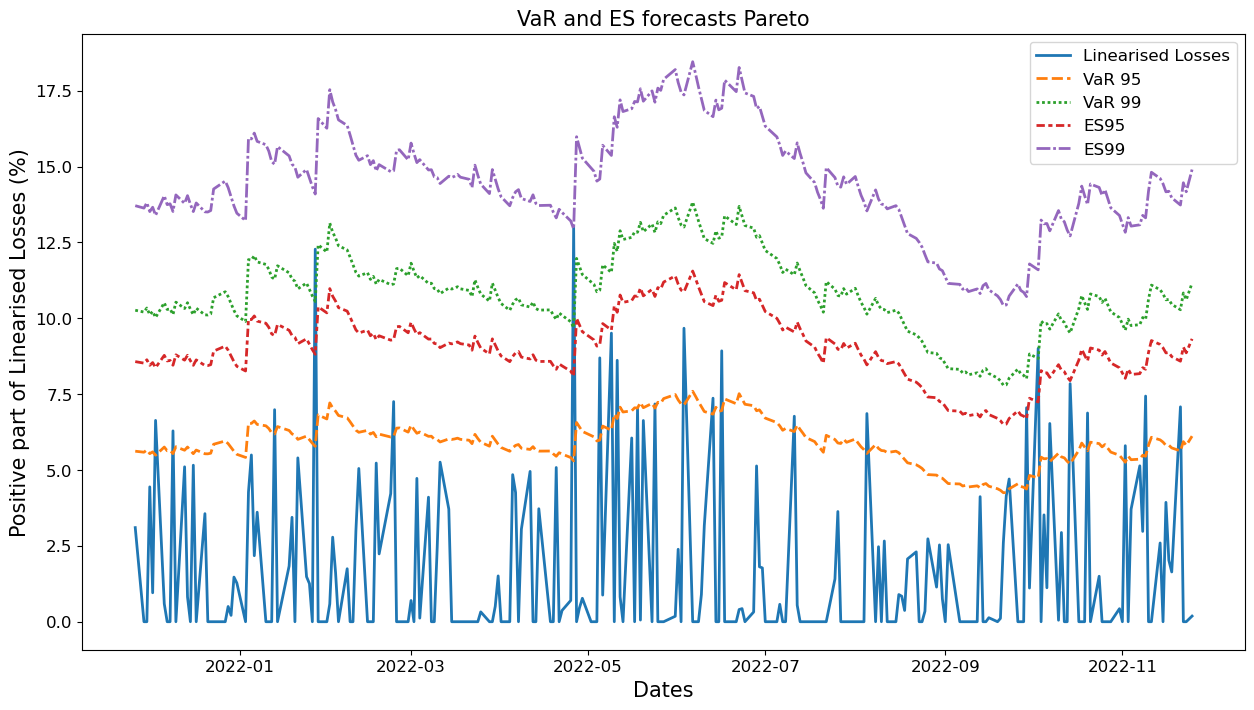

In [67]:
plt.figure(figsize=(15,8))
df_to_plot=pd.DataFrame({"Linearised Losses":y,"VaR 95":var95_pareto,"VaR 99":var99_pareto,"ES95":ES95_pareto,"ES99":ES99_pareto}, index=index)
sns.lineplot(data=df_to_plot,linewidth=2)
plt.title("VaR and ES forecasts Pareto",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [68]:
LRuc95=Unconditional_Test(test_data,var95_pareto,0.95)
pval95=1-stats.chi2.cdf(LRuc95,1)
print(LRuc95)
print(pval95)

Number of violations: 24
Pi hat: 0.09523809523809523
8.680821925483624
0.0032157592747376063


In [69]:
LRuc99=Unconditional_Test(test_data,var99_pareto,0.99)
pval99=1-stats.chi2.cdf(LRuc99,1)
print(LRuc99)
print(pval99)

Number of violations: 3
Pi hat: 0.011904761904761904
0.08704443664798996
0.7679687153509303
